In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import sympy as sp
from sidarthe_functions_and_classes import *

from sklearn.linear_model import LinearRegression
from pymoo.visualization.heatmap import Heatmap
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [2]:
%matplotlib notebook

Wir schauen uns zunächst das System aus https://doi.org/10.1101/2020.12.01.20241885 an. Die default-Werte sind die Werte für $c=(0,0,0)$

In [3]:
# covid model class
class Covid_model:
    """Handles the Covid-Model"""

    def __init__(self,
                 k_E: float = 1.69,  # parameter for system tuning
                 k_I: float = 0.08,
                 k_SY: float = 0.645,
                 k_H: float = 0.017,
                 k_C: float = 0.174,
                 k_R: float = 0.036,
                 k_D: float = 0.225,
                 k_S: float = 0.192,  # fixed
                 k_q: float = 10.25,  # fixed
                 nCT: float = 9.94,  # fixed
                 n: int = 3500000,  # fixed
                 y0=np.array([3440000, 5000, 4000, 0, 0,
                              0, 0, 50000, 0, 0, 0, 0])
                 ):
        self.k_E = k_E
        self.k_I = k_E
        self.k_SY = k_SY
        self.k_H = k_H
        self.k_C = k_C
        self.k_R = k_R
        self.k_D = k_D
        self.k_S = k_S
        self.k_q = k_q
        self.nCT = nCT
        self.n = n

        self.y0 = y0

        # k_Q is defined as k_Q_factor times CT (y[11])
        self.k_Q_factor = self.k_q*self.nCT/self.n

    def matrix_k_E(self):
        S = 0.9
        return lambda k_E: np.array([
            [-self.k_I, k_E*S/self.n, 0, 0, 0, 0, 0, 0, 0],
            [self.k_I, -(self.k_R+self.k_SY), 0, 0, 0, 0, 0, 0, 0],
            [0, self.k_SY, -(self.k_R+self.k_H), 0, 0, 0, 0, self.k_SY, 0],
            [0, 0, self.k_H, -(self.k_R+self.k_C), 0, 0, 0, 0, 0],
            [0, 0, 0, self.k_C, -(self.k_R+self.k_D), 0, 0, 0, 0],
            [0, 0, 0, 0, 0, -self.k_S, 0, 0, self.k_q*self.nCT/self.n*S],
            [0, 0, 0, 0, 0, 0, -self.k_I, 0, 0],
            [0, 0, 0, 0, 0, 0, self.k_I, -(self.k_SY+self.k_R), 0],
            [0, self.k_SY, 0, 0, 0, 0, 0, 0, 0]])

    def dF_factory(self):
        return lambda t, y: np.array([
            -self.k_E*(y[0]*y[2]/self.n) + self.k_S *
            y[8] - self.k_Q_factor*y[11]*y[0],
            self.k_E*(y[0]*y[2]/self.n) -
            (self.k_I+self.k_Q_factor*y[11])*y[1],
            self.k_I*y[1] - (self.k_R+self.k_SY+self.k_Q_factor*y[11])*y[2],
            self.k_SY*(y[2]+y[10]) - (self.k_R+self.k_H)*y[3],
            self.k_H*y[3] - (self.k_R+self.k_C)*y[4],
            self.k_C*y[4] - (self.k_R+self.k_D)*y[5],
            self.k_D*y[5],
            self.k_R*(y[2]+y[3]+y[4]+y[5]+y[10]),
            -self.k_S*y[8] + self.k_Q_factor*y[11]*y[0],
            -self.k_I*y[9] + self.k_Q_factor*y[11]*y[1],
            self.k_I*y[9] + self.k_Q_factor*y[11] *
            y[2] - (self.k_SY+self.k_R)*y[10],
            self.k_SY*y[2] - self.k_q*(y[0]+y[1]+y[2])/self.n*y[11]
        ])

    def simulation(self,  t_0: int = 0, t_end: int = 200, steps_per_day: int = 1):
        dF = self.dF_factory()

        t = np.linspace(t_0, t_end, steps_per_day*(t_end-t_0) + 1)
        y = np.zeros((len(t), len(self.y0)))  # array for solution
        y[0, :] = self.y0

        r = integrate.ode(dF).set_integrator("dopri5")
        r.set_initial_value(self.y0, t_0)  # initial values

        for i in range(1, t.size):
            # get one more value, add it to the array
            y[i, :] = r.integrate(t[i])
            if not r.successful():
                raise RuntimeError("Could not integrate")
        return t, y

    def plot_all_single(self, t, y) -> None:
        """doc"""
        #plt.figure(figsize=(16, 9), dpi=160)
        plt.figure(figsize=(16, 9), dpi=80)

        plt.subplot(3, 4, 1)
        plt.plot(t, y[:, 0])
        plt.title("$S$")

        plt.subplot(3, 4, 2)
        plt.plot(t, y[:, 1])
        plt.title("$E$")

        plt.subplot(3, 4, 3)
        plt.plot(t, y[:, 2])
        plt.title("$I$")

        plt.subplot(3, 4, 4)
        plt.plot(t, y[:, 3])
        plt.title("$S_Y$")

        plt.subplot(3, 4, 5)
        plt.plot(t, y[:, 4])
        plt.title("$H$")

        plt.subplot(3, 4, 6)
        plt.plot(t, y[:, 5])
        plt.title("$C$")

        plt.subplot(3, 4, 7)
        plt.plot(t, y[:, 6])
        plt.title("$D$")

        plt.subplot(3, 4, 8)
        plt.plot(t, y[:, 7])
        plt.title("$R$")

        plt.subplot(3, 4, 9)
        plt.plot(t, y[:, 8])
        plt.title("$Q_S$")

        plt.subplot(3, 4, 10)
        plt.plot(t, y[:, 9])
        plt.title("$Q_E$")

        plt.subplot(3, 4, 11)
        plt.plot(t, y[:, 10])
        plt.title("$Q_I$")

        plt.subplot(3, 4, 12)
        plt.plot(t, y[:, 11])
        plt.title("$CT$")

        plt.subplots_adjust(top=0.92,
                            bottom=0.08,
                            left=0.10,
                            right=0.95,
                            hspace=.5,
                            wspace=.5)

        plt.show()

### Covid-Modell Berlin

Die nachfolgenden Plots zeigen einen "normalen" Verlauf des Systems.

<IPython.core.display.Javascript object>


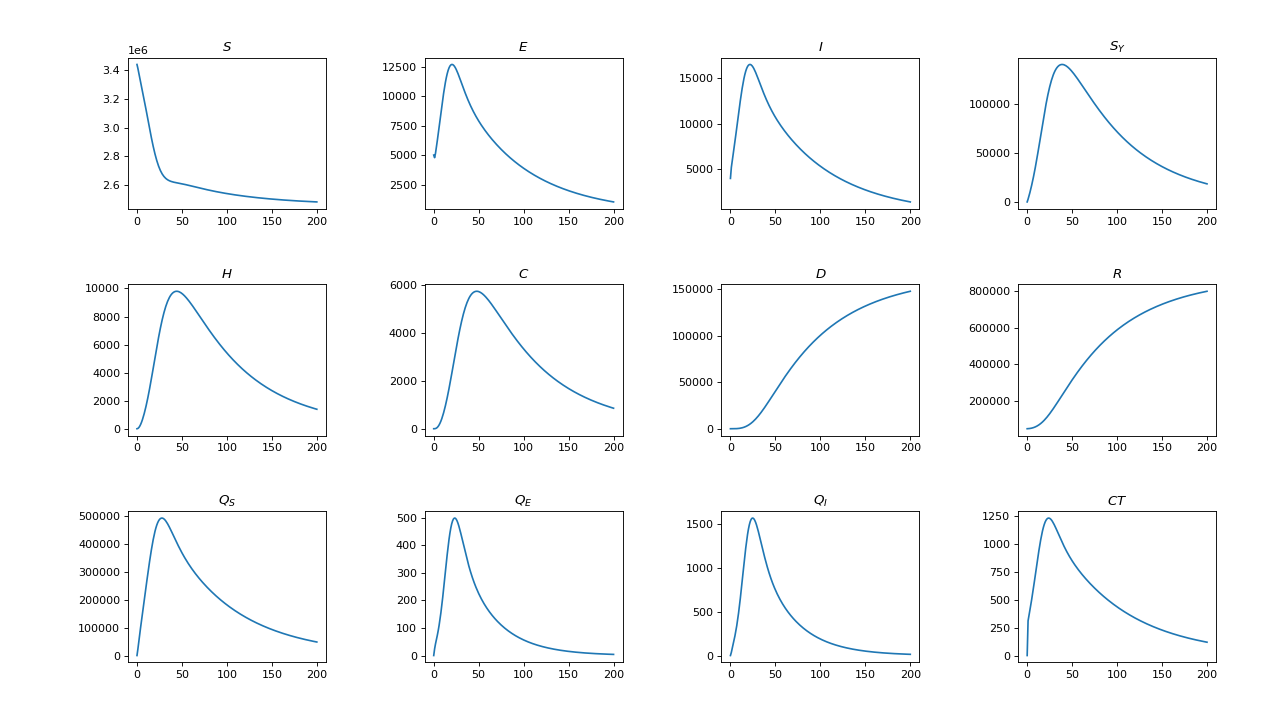

In [4]:
# cm = Covid_model(k_E=0.9)
# optimal_params: k_I=0.095, k_SY=0.61, k_H=0.016, k_C=0.18, k_R=0.045, k_D=0.26 (page 23)
cm = Covid_model(k_E=0.9, k_I=0.095, k_SY=0.61, k_H=0.016, k_C=0.18, k_R=0.045, k_D=0.26)

t, y = cm.simulation()

cm.plot_all_single(t, y)

### SIDARTHE Modell

Zur Erinnerung plotten wir dagegen nochmal einen "normalen" Verlauf des SIDARTHE Systems.

<IPython.core.display.Javascript object>


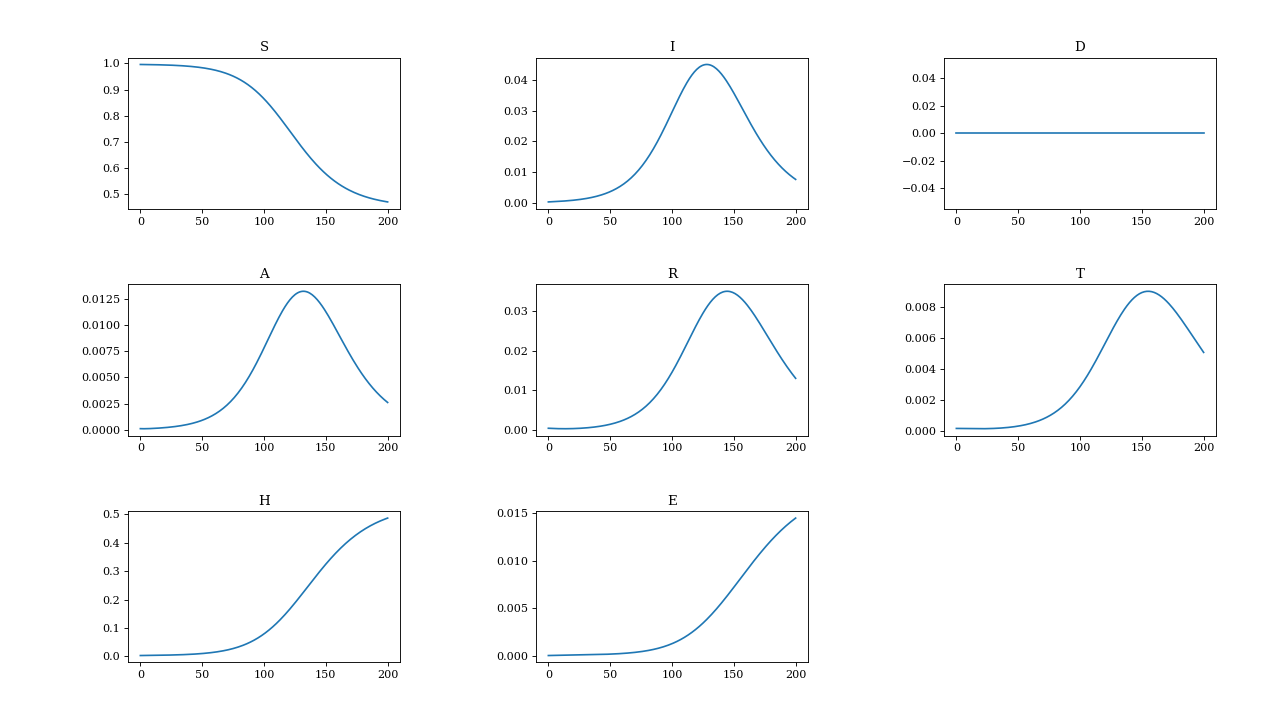

In [13]:
p = Parameters8(alpha=0.15, gamma=0.15)
t, y = sidarthe_simulation8(p, t_end=200)
plot_all_single_8(t, y)

### Linearisierung

In [6]:
# define symbols and matrix for the system
S = sp.symbols("S")
k_E = sp.symbols("k_E")
k_I = sp.symbols("k_I")
k_SY = sp.symbols("k_SY")
k_H = sp.symbols("k_H")
k_C = sp.symbols("k_C")
k_R = sp.symbols("k_R")
k_D = sp.symbols("k_D")
k_S = sp.symbols("k_S")
k_q = sp.symbols("k_q")
k_Q = sp.symbols("k_Q")
N = sp.symbols("N")
nCT = sp.symbols("nCT")

# symbolic matrix
M = sp.Matrix([[0, 0, -k_E*S/N, 0, 0, 0, 0, 0, k_S, 0, 0, -k_q*nCT/N*S],
               [0, -k_I, k_E*S/N, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, k_I, -(k_R+k_SY), 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, k_SY, -(k_R+k_H), 0, 0, 0, 0, 0, 0, k_SY, 0],
               [0, 0, 0, k_H, -(k_R+k_C), 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, k_C, -(k_R+k_D), 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, k_C, 0, 0, 0, 0, 0, 0],
               [0, 0, k_R, k_R, k_R, k_R, 0, 0, 0, 0, k_R, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, -k_S, 0, 0, k_q*nCT/N*S],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, -k_I, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, k_I, -(k_SY+k_R), 0],
               [0, 0, k_SY, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

M

Matrix([
[0,    0,    -S*k_E/N,          0,          0,          0, 0, 0,  k_S,    0,           0, -S*k_q*nCT/N],
[0, -k_I,     S*k_E/N,          0,          0,          0, 0, 0,    0,    0,           0,            0],
[0,  k_I, -k_R - k_SY,          0,          0,          0, 0, 0,    0,    0,           0,            0],
[0,    0,        k_SY, -k_H - k_R,          0,          0, 0, 0,    0,    0,        k_SY,            0],
[0,    0,           0,        k_H, -k_C - k_R,          0, 0, 0,    0,    0,           0,            0],
[0,    0,           0,          0,        k_C, -k_D - k_R, 0, 0,    0,    0,           0,            0],
[0,    0,           0,          0,          0,        k_C, 0, 0,    0,    0,           0,            0],
[0,    0,         k_R,        k_R,        k_R,        k_R, 0, 0,    0,    0,         k_R,            0],
[0,    0,           0,          0,          0,          0, 0, 0, -k_S,    0,           0,  S*k_q*nCT/N],
[0,    0,           0,          0,          0,

In [7]:
# reduced matrix
R = sp.Matrix([
    [-k_I, k_E*S/N, 0, 0, 0, 0, 0, 0, 0],
    [k_I, -(k_R+k_SY), 0, 0, 0, 0, 0, 0, 0],
    [0, k_SY, -(k_R+k_H), 0, 0, 0, 0, k_SY, 0],
    [0, 0, k_H, -(k_R+k_C), 0, 0, 0, 0, 0],
    [0, 0, 0, k_C, -(k_R+k_D), 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -k_S, 0, 0, k_q*nCT/N*S],
    [0, 0, 0, 0, 0, 0, -k_I, 0, 0],
    [0, 0, 0, 0, 0, 0, k_I, -(k_SY+k_R), 0],
    [0, k_SY, 0, 0, 0, 0, 0, 0, 0]])


# print(R.eigenvals(multiple=True))
R

Matrix([
[-k_I,     S*k_E/N,          0,          0,          0,    0,    0,           0,           0],
[ k_I, -k_R - k_SY,          0,          0,          0,    0,    0,           0,           0],
[   0,        k_SY, -k_H - k_R,          0,          0,    0,    0,        k_SY,           0],
[   0,           0,        k_H, -k_C - k_R,          0,    0,    0,           0,           0],
[   0,           0,          0,        k_C, -k_D - k_R,    0,    0,           0,           0],
[   0,           0,          0,          0,          0, -k_S,    0,           0, S*k_q*nCT/N],
[   0,           0,          0,          0,          0,    0, -k_I,           0,           0],
[   0,           0,          0,          0,          0,    0,  k_I, -k_R - k_SY,           0],
[   0,        k_SY,          0,          0,          0,    0,    0,           0,           0]])

Das in Kapitel 4.1 betrachtete Optimierungsproblem ist extrem startk vereinfacht. Wir versuchen zunächst, die Ergebnisse mir dem NSGA-2 Algorithmus nachzustellen und später möchten wir eine Subdivision-Methode implementieren. Die zu minimierenden Zielfunktionen lauten:

\begin{equation}
    \begin{aligned}
        J_1 := & ~3c_1^2 + 0.4c_2 + 0.6c_3 \\
        J_2 := & ~S_Y(t_{end})
    \end{aligned}
\end{equation}

Die Designparameter $c=(c_1,~c_2,~c_3)$ werden durch $c\in [0,~1]^3$ beschränkt.

---

Mit dem ABM wurden 27 Szenarien $(c_1,~ c_2,~ c_3)$ simuliert. Mit diesen Simulationen wurden Werte für den Parameter $k_E$ abgeleitet. Aus diesen 27 Werten wird im Folgenden durch Regression eine Funktion erstellt, die aus den Werten $c_i \in [0,1]$ den Parameterwert $k_E$ berechnet.

Der Datensatz wird nicht auf github veröffentlicht. Deshalb ist der benutzte Code in diesem Markdown zu finden.

    # the dataset will not be published on github
    data_27 = np.genfromtxt('kE_values_for_27_datasets.csv', delimiter=',')
    data_27 = data_27[1:] # remove nan / header
    
    # counter measures c1, c2, c3 in percent  and transform percentages to decimals
    x_data = data_27[:,:-1]/100
    # add quadratic terms
    x_data = np.append(x_data, x_data**2, axis = 1)
    # parameter values k_E
    y_data = data_27[:,-1]

    model = LinearRegression()
    model.fit(x_data, y_data)
    print("Model intercept: {}".format(model.intercept_))
    print("Model coefficients for: c1, c2, c3, c1^2, c2^2, c3^2: \n", model.coef_)
    
---
Output:

    Model intercept: 1.2249888888888891
    Model coefficients for: c1, c2, c3, c1^2, c2^2, c3^2: 
     [-0.13907778 -0.11484444 -0.35371111  0.0722     -0.00613333  0.1308    ]

In [8]:
def socioeco_cost(c):
    """Calculate socio-economic cost."""
    return 3*c[0]**2 + 0.4*c[1] + 0.6*c[2]


def calculate_infection_rate(c):
    """Calculate infection rate dependent on counter measure vector c."""
    raise NotImplementedError("Can't find coefficients in paper.")


def temp_calculate_infection_rate(c):
    """Calculate infection rate dependent on counter measure vector c."""
    # 1.2 - 0.05*c[0] - 0.1*c[1] - 0.26*c[2]
    # old: np.sum(1-c)*0.5 - c[1]*0.5
    return 1.2 - 0.05*c[0] - 0.1*c[1] - 0.26*c[2] + 0.08*c[2]**2


def real_calculate_infection_rate(c):
    """
    Calculate infection rate dependent on counter measure vector c.
    Values from regression with data send by Hanna Wulkow.
    """
    k_E = 1.224988888888889 - 0.13907778 * \
        c[0] - 0.11484444*c[1] - 0.35371111*c[2] + 0.0722 * \
        c[0]**2 - 0.00613333*c[1]**2 + 0.1308*c[2]**2
    return k_E


def final_symptomatic(c, cm, t_0, t_end, from_data=True):
    """
    Run covid sim and return final value for symptomatic individuals.
    WARNING! Also changes k_E parameter in covid model
    """
    if from_data:
        cm.k_E = real_calculate_infection_rate(c)  # update parameter k_E:=k_E(c)
    else:
        cm.k_E = temp_calculate_infection_rate(c)  # update parameter k_E:=k_E(c)
    y = cm.simulation(t_0=t_0, t_end=t_end)[1]
    return y[-1, 3]  # last value for S_Y

In [9]:
cm = Covid_model(k_E=0.9, k_I=0.095, k_SY=0.61,
                 k_H=0.016, k_C=0.18, k_R=0.045, k_D=0.26)


class Zuse_problem(Problem):

    def __init__(self, t_0, t_end, cov_model):
        super().__init__(n_var=3,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array(3*[0]),
                         xu=np.array(3*[1]),
                         elementwise_evaluation=True)
        
        self.obj2 = lambda c: final_symptomatic(c, cm=cov_model,
                               t_0=t_0, t_end=t_end, from_data=False)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = socioeco_cost(c=x)
        f2 = self.obj2(x)
        
        g1 = np.sum(x) -3

        out["F"] = [f1, f2]
        out ["G"] = [g1]


problem = Zuse_problem(t_0=0, t_end=50, cov_model=cm)

algorithm = NSGA2(pop_size=200, eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ("n_gen", 25),
               verbose=True,
               save_history=True,
               seed=42)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     200 |  0.00000E+00 |  0.00000E+00 |      32 |            - |            -
    2 |     400 |  0.00000E+00 |  0.00000E+00 |      40 |  0.007383577 |            f
    3 |     600 |  0.00000E+00 |  0.00000E+00 |      59 |  0.010007041 |        ideal
    4 |     800 |  0.00000E+00 |  0.00000E+00 |      84 |  0.025811705 |        ideal
    5 |    1000 |  0.00000E+00 |  0.00000E+00 |     130 |  0.013629673 |        ideal
    6 |    1200 |  0.00000E+00 |  0.00000E+00 |     159 |  0.004490461 |        ideal
    7 |    1400 |  0.00000E+00 |  0.00000E+00 |     200 |  0.006985774 |        nadir
    8 |    1600 |  0.00000E+00 |  0.00000E+00 |     200 |  0.005628826 |        ideal
    9 |    1800 |  0.00000E+00 |  0.00000E+00 |     200 |  0.054784201 |        nadir
   10 |    2000 |  0.00000E+00 |  0.00000E+00 |     200 |  0.069751051 |        nadir
   11 |    2200 |  0.00000E+00 |  0.00000E+00 |     20

[3.22686229e+00 1.23097510e+05]
[0.86167523 0.99963841 0.99925715]


<IPython.core.display.Javascript object>


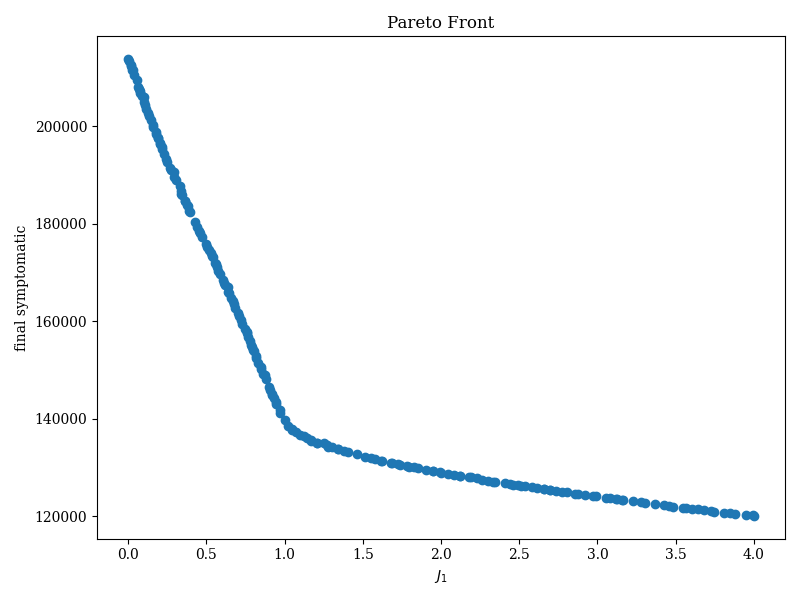

<IPython.core.display.Javascript object>


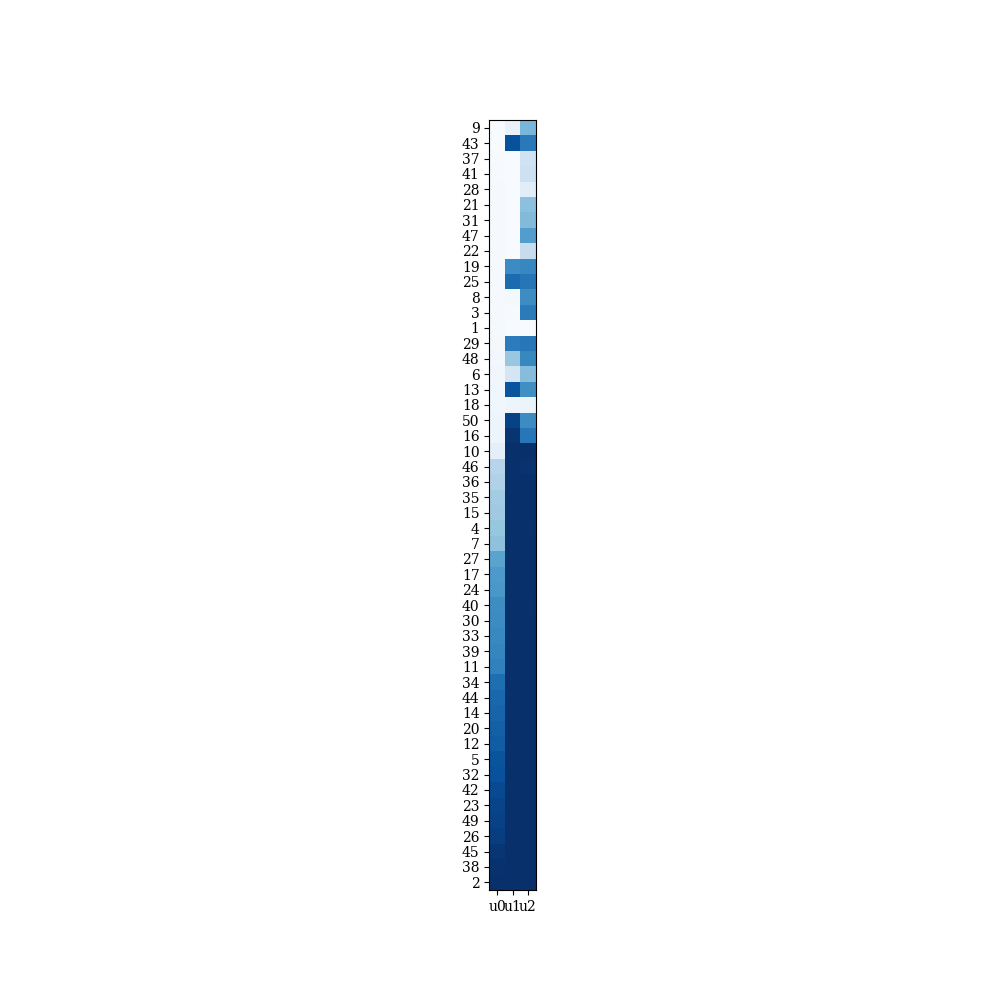

<IPython.core.display.Javascript object>


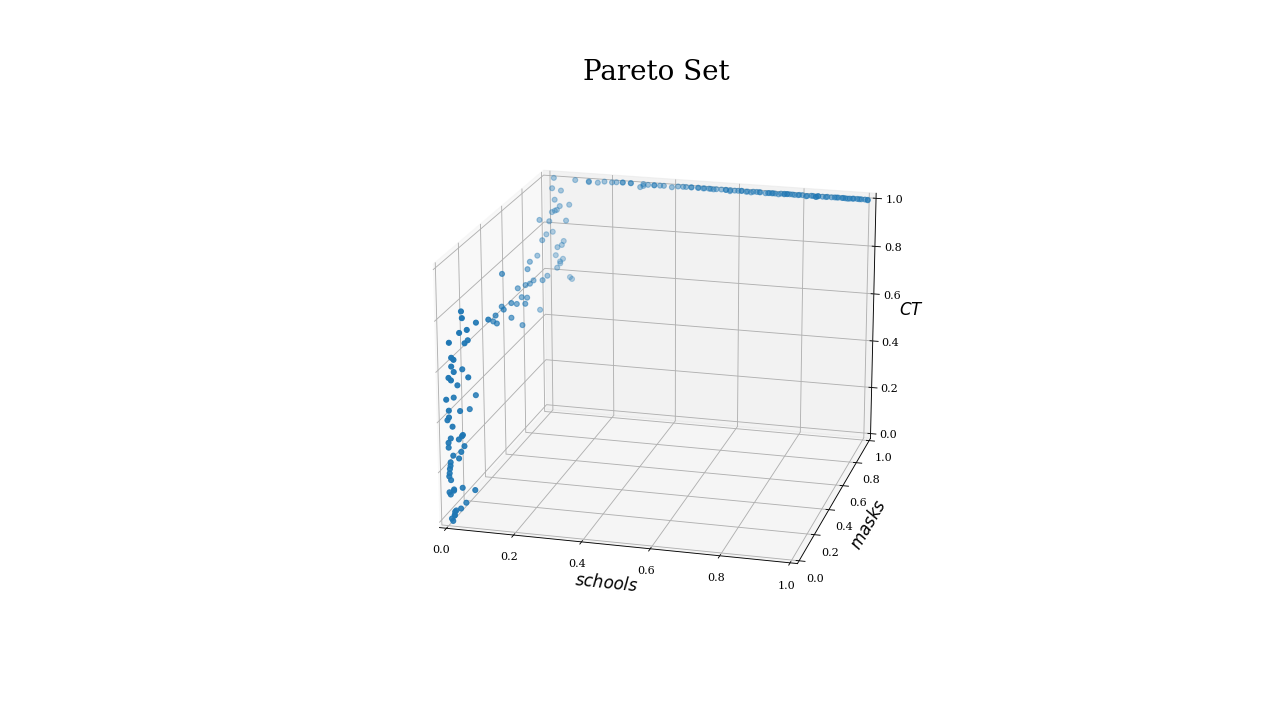

In [10]:
index = 4

if res.F is not None:
    if len(res.F) >= index:
        print(res.F[index])
        print(res.X[index])
    else:
        print(res.F[-1])
        print(res.X[-1])

    plot = Scatter(tight_layout=True, title = "Pareto Front", labels=['$J_1$', 'final symptomatic'])
    plot.add(res.F)
    plot.show()
    
    plot2 = Heatmap(reverse=False, order_by_objectives=0, figsize=(10, 10), labels=["u"+str(i) for i in range(res.X.shape[1])])
    plot2.add(res.X[:50])
    plot2.show()
    
    fig = plt.figure(figsize=(16, 9), dpi=80)
    axes = fig.add_subplot(projection='3d', xlim=[0,1], ylim=[0,1], zlim=[0,1])
    axes.set_title("Pareto Set", fontsize=25)
    axes.set_xlabel("$schools$", fontsize=15)
    axes.set_ylabel("$masks$", fontsize=15)
    axes.set_zlabel("$CT$", fontsize=15)
    axes.scatter(res.X[:,0], res.X[:,1], res.X[:,2])
    axes.view_init(12, -55)
    plt.show()

else:
    print("No solutions.")   

In [11]:
cm = Covid_model(k_E=0.9, k_I=0.095, k_SY=0.61,
                 k_H=0.016, k_C=0.18, k_R=0.045, k_D=0.26)


class Zuse_problem_from_data(Problem):

    def __init__(self, t_0, t_end, cov_model):
        super().__init__(n_var=3,
                         n_obj=2,
                         n_constr=1,
                         xl=np.array(3*[0]),
                         xu=np.array(3*[1]),
                         elementwise_evaluation=True)
        
        self.obj2 = lambda c: final_symptomatic(c, cm=cov_model,
                               t_0=t_0, t_end=t_end, from_data=True)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = socioeco_cost(c=x)
        f2 = self.obj2(x)
        
        g1 = np.sum(x) -3

        out["F"] = [f1, f2]
        out ["G"] = [g1]


problem = Zuse_problem_from_data(t_0=0, t_end=50, cov_model=cm)

algorithm = NSGA2(pop_size=1000, eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ("n_gen", 25),
               verbose=True,
               save_history=True,
               seed=42)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |    1000 |  0.00000E+00 |  0.00000E+00 |      62 |            - |            -
    2 |    2000 |  0.00000E+00 |  0.00000E+00 |     100 |  0.004293328 |            f
    3 |    3000 |  0.00000E+00 |  0.00000E+00 |     136 |  0.007417825 |        ideal
    4 |    4000 |  0.00000E+00 |  0.00000E+00 |     180 |  0.012538497 |        ideal
    5 |    5000 |  0.00000E+00 |  0.00000E+00 |     231 |  0.013588162 |        ideal
    6 |    6000 |  0.00000E+00 |  0.00000E+00 |     307 |  0.001760206 |            f
    7 |    7000 |  0.00000E+00 |  0.00000E+00 |     403 |  0.117663296 |        nadir
    8 |    8000 |  0.00000E+00 |  0.00000E+00 |     501 |  0.075053250 |        nadir
    9 |    9000 |  0.00000E+00 |  0.00000E+00 |     620 |  0.066331290 |        nadir
   10 |   10000 |  0.00000E+00 |  0.00000E+00 |     763 |  0.003965751 |        ideal
   11 |   11000 |  0.00000E+00 |  0.00000E+00 |     91

[3.71036878e+00 9.32209033e+04]
[0.95051327 0.99997341 0.99992165]


<IPython.core.display.Javascript object>


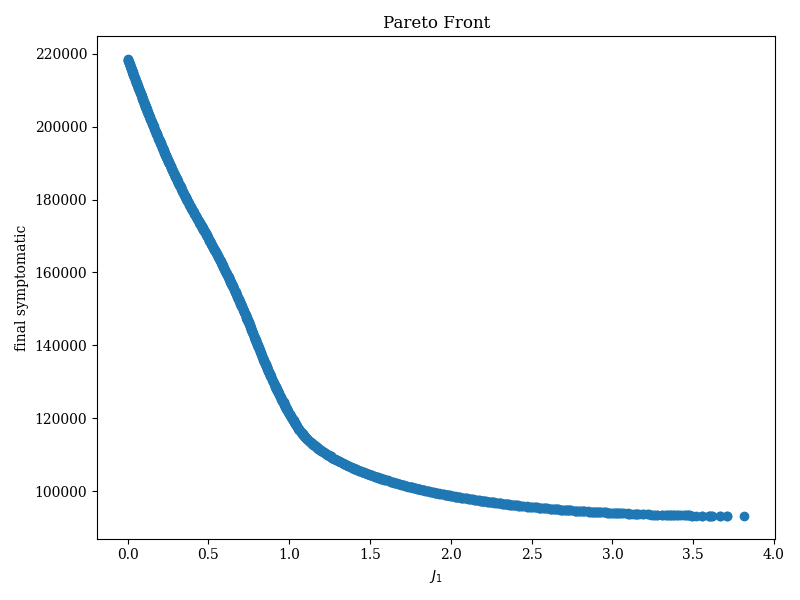

<IPython.core.display.Javascript object>


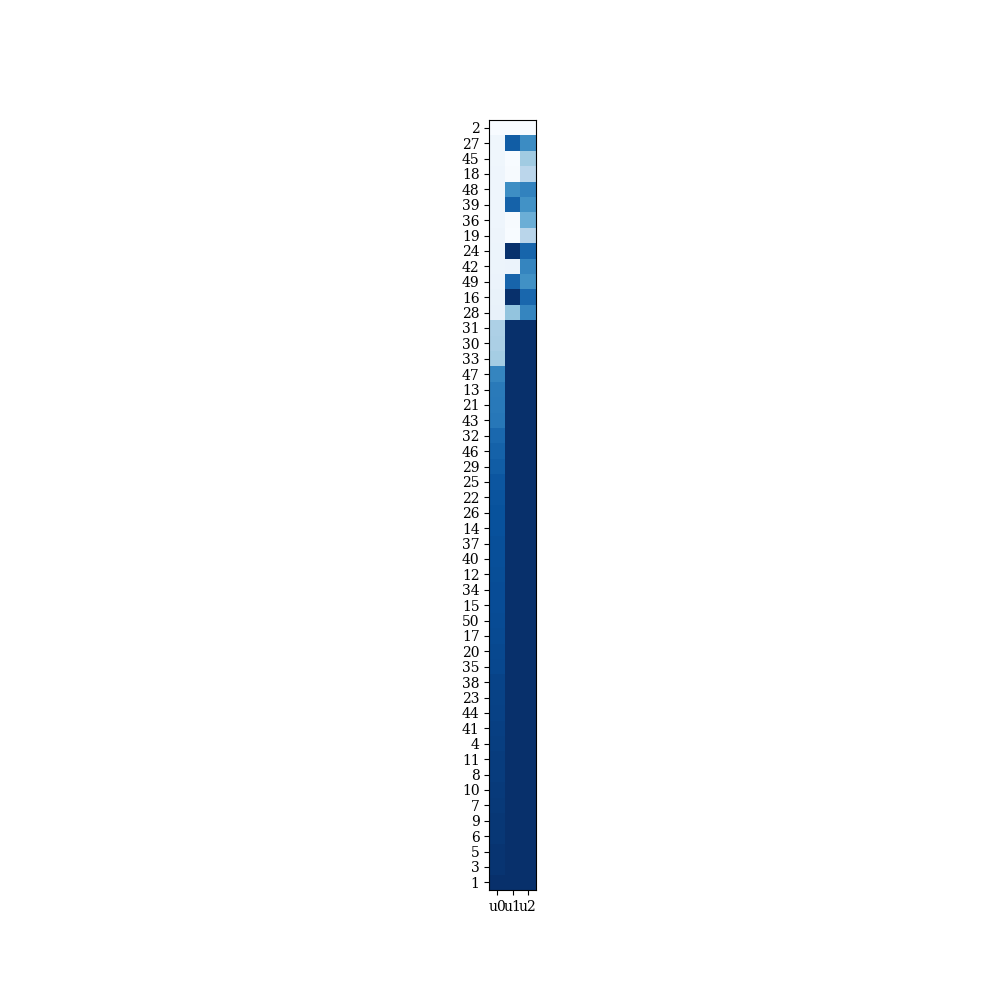

<IPython.core.display.Javascript object>


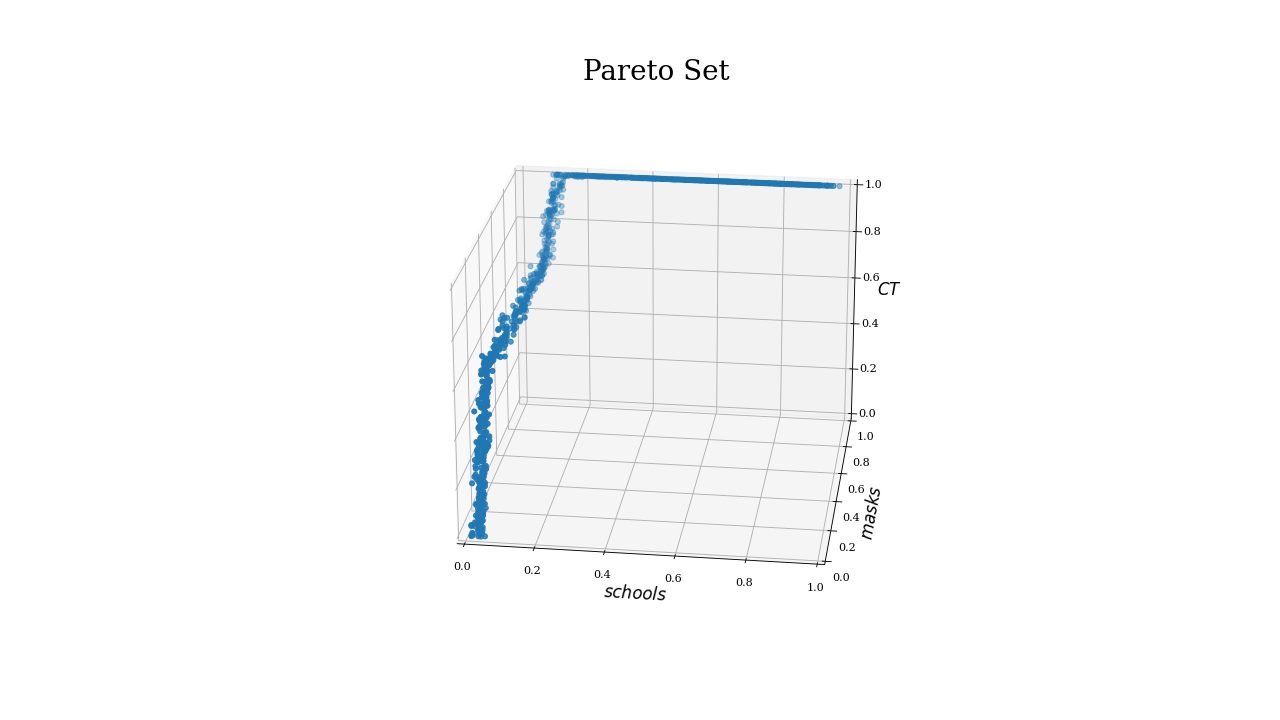

In [12]:
index = 4

if res.F is not None:
    if len(res.F) >= index:
        print(res.F[index])
        print(res.X[index])
    else:
        print(res.F[-1])
        print(res.X[-1])

    plot3 = Scatter(tight_layout=True, title = "Pareto Front", labels=['$J_1$', 'final symptomatic'])
    plot3.add(res.F)
    plot3.show()
    
    plot4 = Heatmap(reverse=False, order_by_objectives=0, figsize=(10, 10), labels=["u"+str(i) for i in range(res.X.shape[1])])
    plot4.add(res.X[:50])
    plot4.show()
    
    fig2 = plt.figure(figsize=(16, 9), dpi=80)
    axes = fig2.add_subplot(projection='3d', xlim=[0,1], ylim=[0,1], zlim=[0,1])
    axes.set_title("Pareto Set", fontsize=25)
    axes.set_xlabel("$schools$", fontsize=15)
    axes.set_ylabel("$masks$", fontsize=15)
    axes.set_zlabel("$CT$", fontsize=15)
    axes.scatter(res.X[:,0], res.X[:,1], res.X[:,2])
    axes.view_init(12, -55)
    plt.show()

else:
    print("No solutions.")